In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix as sk_confusion_matrix

In [2]:
def euclidean_distance(x1, x2):
    """Calculate Euclidean distance between two points"""
    return np.sqrt(np.sum((x1 - x2) ** 2))

def normalize_features(X_train, X_test):
    """Z-score normalization of features"""
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    std[std == 0] = 1e-10  # Avoid division by zero

    X_train_norm = (X_train - mean) / std
    X_test_norm = (X_test - mean) / std
    return X_train_norm, X_test_norm

def evaluate(y_true, y_pred):
    """Calculate accuracy score"""
    return np.sum(y_true == y_pred) / len(y_true)

def enhanced_map_clusters_to_speakers(cluster_labels, true_labels):
    """Advanced mapping from clusters to speaker labels"""
    unique_clusters = np.unique(cluster_labels)
    unique_speakers = np.unique(true_labels)

    # Calculate confusion matrix between clusters and speakers
    confusion = np.zeros((len(unique_clusters), len(unique_speakers)))
    for i, cluster in enumerate(unique_clusters):
        for j, speaker in enumerate(unique_speakers):
            confusion[i, j] = np.sum((cluster_labels == cluster) & (true_labels == speaker))

    purity = np.zeros(len(unique_clusters))
    mapping = {}

    # First pass: assign high-confidence mappings
    assigned_speakers = set()
    for i, cluster in enumerate(unique_clusters):
        cluster_sum = np.sum(confusion[i])
        if cluster_sum > 0:
            purity[i] = np.max(confusion[i]) / cluster_sum
            if purity[i] >= 0.7:
                speaker_idx = np.argmax(confusion[i])
                speaker = unique_speakers[speaker_idx]
                mapping[cluster] = speaker
                assigned_speakers.add(speaker)

    # Second pass: assign remaining clusters
    for i, cluster in enumerate(unique_clusters):
        if cluster not in mapping:
            cluster_sum = np.sum(confusion[i])
            if cluster_sum > 0:
                # Get top speaker candidates
                top_indices = np.argsort(-confusion[i])[:3]

                # Try to assign to unassigned speakers first
                assigned = False
                for idx in top_indices:
                    speaker = unique_speakers[idx]
                    if speaker not in assigned_speakers and confusion[i, idx] > 0:
                        mapping[cluster] = speaker
                        assigned_speakers.add(speaker)
                        assigned = True
                        break

                if not assigned:
                    speaker_idx = np.argmax(confusion[i])
                    mapping[cluster] = unique_speakers[speaker_idx]
            else:
                mapping[cluster] = unique_speakers[0]

    # Map prediction labels
    mapped_labels = np.array([mapping[label] for label in cluster_labels])
    print(f"Average cluster purity: {np.mean(purity):.4f}")

    return mapped_labels

In [3]:
class CustomPCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.mean = None
        self.explained_variance = None

    def fit(self, X):
        """Learn principal components from training data"""
        # Mean centering (essential for PCA)
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean

        # Covariance matrix (key to PCA's variance maximization)
        cov_matrix = np.cov(X_centered, rowvar=False)

        # Eigen decomposition (mathematical core of PCA)
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

        # Sort components by descending eigenvalues
        sorted_idx = np.argsort(eigenvalues)[::-1]

        # Handle n_components as variance explained ratio
        if 0 < self.n_components < 1:
            # Cumulative explained variance
            cumulative_variance_ratio = np.cumsum(eigenvalues[sorted_idx]) / np.sum(eigenvalues[sorted_idx])
            # Number of components to retain desired variance
            self.n_components = np.argmax(cumulative_variance_ratio >= self.n_components) + 1

        self.components = eigenvectors[:, sorted_idx][:, :self.n_components]
        self.explained_variance = eigenvalues[sorted_idx][:self.n_components]

    def transform(self, X):
        """Project data onto principal components"""
        X_centered = X - self.mean
        return X_centered @ self.components

In [4]:
def calculate_inertia(X, labels, centroids):
    """Calculate inertia (sum of squared distances to centroids)"""
    inertia = 0
    for i, point in enumerate(X):
        inertia += euclidean_distance(point, centroids[labels[i]]) ** 2
    return inertia

def calculate_cluster_purity(cluster_labels, true_labels):
    """Calculate purity for each cluster"""
    unique_clusters = np.unique(cluster_labels)
    unique_speakers = np.unique(true_labels)

    # Calculate confusion matrix
    confusion = np.zeros((len(unique_clusters), len(unique_speakers)))
    for i, cluster in enumerate(unique_clusters):
        for j, speaker in enumerate(unique_speakers):
            confusion[i, j] = np.sum((cluster_labels == cluster) & (true_labels == speaker))

    # Calculate purity for each cluster
    cluster_purities = {}
    cluster_sizes = {}

    for i, cluster in enumerate(unique_clusters):
        cluster_sum = np.sum(confusion[i])
        if cluster_sum > 0:
            purity = np.max(confusion[i]) / cluster_sum
            cluster_purities[cluster] = purity
            cluster_sizes[cluster] = cluster_sum

    return cluster_purities, cluster_sizes, confusion

Plotting Functions

In [5]:
def plot_inertia_vs_k(k_values, inertia_values, optimal_k):
    """Plot Inertia vs K (Elbow Method)"""
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, inertia_values, 'o-', linewidth=2, markersize=8)
    plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal K={optimal_k}')
    plt.xlabel('Number of Clusters (K)', fontsize=12)
    plt.ylabel('Inertia', fontsize=12)
    plt.title('Elbow Method for Optimal K', fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_cluster_purity(cluster_purities, cluster_sizes, optimal_k):
    """Plot cluster purity as a bar chart"""
    # Sort clusters by size (descending)
    sorted_clusters = sorted(cluster_purities.keys(), key=lambda k: cluster_sizes[k], reverse=True)
    purities = [cluster_purities[k] for k in sorted_clusters]
    sizes = [cluster_sizes[k] for k in sorted_clusters]

    # Limit to top 20 clusters if there are many
    if len(sorted_clusters) > 20:
        sorted_clusters = sorted_clusters[:20]
        purities = purities[:20]
        sizes = sizes[:20]

    # Create bar chart
    plt.figure(figsize=(12, 6))
    bars = plt.bar(range(len(sorted_clusters)), purities, color='skyblue')

    # Color bars by purity
    for i, purity in enumerate(purities):
        if purity >= 0.9:
            bars[i].set_color('darkgreen')
        elif purity >= 0.7:
            bars[i].set_color('yellowgreen')
        elif purity >= 0.5:
            bars[i].set_color('orange')
        else:
            bars[i].set_color('salmon')

    # Add size annotations
    for i, (purity, size) in enumerate(zip(purities, sizes)):
        plt.annotate(f'{size}', xy=(i, purity+0.02), ha='center', fontsize=9)

    plt.xlabel('Cluster Index (sorted by size)', fontsize=12)
    plt.ylabel('Purity', fontsize=12)
    plt.title(f'Cluster Purity for K={optimal_k}', fontsize=14)
    plt.ylim(0, 1.1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

def plot_speaker_distribution(confusion_matrix, unique_clusters, unique_speakers, optimal_k):
    """Plot speaker distribution across clusters as stacked bar plot"""
    # Select top clusters by size
    cluster_sizes = np.sum(confusion_matrix, axis=1)
    top_indices = np.argsort(-cluster_sizes)[:min(15, len(unique_clusters))]

    # Get top speakers in each cluster
    speakers_per_cluster = {}
    for i in top_indices:
        cluster = unique_clusters[i]
        # Get top 5 speakers in this cluster
        top_speaker_indices = np.argsort(-confusion_matrix[i])[:5]
        speakers = [(unique_speakers[j], confusion_matrix[i][j]) for j in top_speaker_indices
                  if confusion_matrix[i][j] > 0]
        speakers_per_cluster[cluster] = speakers

    # Create stacked bar chart
    plt.figure(figsize=(14, 8))

    # Prepare data for stacking
    bottoms = np.zeros(len(speakers_per_cluster))
    cluster_indices = list(range(len(speakers_per_cluster)))
    cluster_labels = list(speakers_per_cluster.keys())

    # Use a colormap
    colors = plt.cm.tab20(np.linspace(0, 1, 20))
    speaker_color_map = {}

    # Plot each speaker's contribution to each cluster
    legend_handles = []
    legend_labels = []

    for speaker_idx in range(5):  # Max 5 speakers per cluster
        heights = []
        for cluster in speakers_per_cluster:
            speakers = speakers_per_cluster[cluster]
            if speaker_idx < len(speakers):
                speaker, count = speakers[speaker_idx]
                heights.append(count)

                # Assign color to speaker
                if speaker not in speaker_color_map:
                    speaker_color_map[speaker] = colors[len(speaker_color_map) % len(colors)]
            else:
                heights.append(0)

        # Plot this speaker's contribution across all clusters
        unique_speakers_in_this_row = set()
        for i, h in enumerate(heights):
            if h > 0:
                speakers = speakers_per_cluster[cluster_labels[i]]
                speaker = speakers[speaker_idx][0]
                if speaker not in unique_speakers_in_this_row:
                    unique_speakers_in_this_row.add(speaker)
                    bar = plt.bar(cluster_indices[i], h, bottom=bottoms[i],
                                 color=speaker_color_map[speaker], label=f'Speaker {speaker}')
                    if speaker not in legend_labels:
                        legend_handles.append(bar)
                        legend_labels.append(f'Speaker {speaker}')
                else:
                    plt.bar(cluster_indices[i], h, bottom=bottoms[i],
                          color=speaker_color_map[speaker])

        # Update bottoms for next stack
        bottoms = [bottoms[i] + heights[i] for i in range(len(heights))]

    plt.xlabel('Cluster Index', fontsize=12)
    plt.ylabel('Number of Samples', fontsize=12)
    plt.title(f'Speaker Distribution in Top Clusters (K={optimal_k})', fontsize=14)
    plt.xticks(cluster_indices, [f'C{c}' for c in cluster_labels], rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

In [6]:
# Performance Comparison Plot (With and Without PCA)
def plot_performance_comparison(metrics_lda_pca, metrics_lda, metrics_raw):
    """Plot comparison of all three approaches"""
    labels = ['Training', 'Validation', 'Test']
    x = np.arange(len(labels))
    width = 0.25

    plt.figure(figsize=(12,6))
    plt.bar(x - width, metrics_lda_pca, width, label='LDA+PCA')
    plt.bar(x, metrics_lda, width, label='LDA Only')
    plt.bar(x + width, metrics_raw, width, label='Raw Features')

    plt.ylabel('Accuracy')
    plt.title('Performance Comparison Across Feature Sets')
    plt.xticks(x, labels)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

Optimal K Search

In [7]:
def find_optimal_k(kmeans_model, X_train, X_val, y_val, k_range):
    """Find optimal K using validation accuracy and track inertia for elbow method"""
    val_accuracies = []
    inertia_values = []

    for k in k_range:
        print(f"Testing K = {k}")
        # Train on training data
        labels, centroids = kmeans_model.fit(X_train, k)

        # Calculate inertia
        inertia = calculate_inertia(X_train, labels, centroids)
        inertia_values.append(inertia)
        print(f"Inertia: {inertia:.2f}")

        # Evaluate on validation
        val_labels = kmeans_model.predict(X_val, centroids)
        mapped_val_labels = enhanced_map_clusters_to_speakers(val_labels, y_val)
        val_acc = evaluate(y_val, mapped_val_labels)
        val_accuracies.append(val_acc)

        print(f"Validation Accuracy: {val_acc:.4f}")

    # Get optimal K
    optimal_k_idx = np.argmax(val_accuracies)
    optimal_k = k_range[optimal_k_idx]

    # Plot validation accuracy
    plt.figure(figsize=(8, 5))
    plt.plot(k_range, val_accuracies, 'o-', color='green')
    plt.axvline(x=optimal_k, color='r', linestyle='--')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Validation Accuracy')
    plt.title(f'Validation Accuracy vs K (Best: {val_accuracies[optimal_k_idx]:.4f} at K={optimal_k})')
    plt.grid(True)
    plt.show()

    # Plot inertia vs K (Elbow Method)
    plot_inertia_vs_k(k_range, inertia_values, optimal_k)

    print(f"Selected K: {optimal_k} (validation accuracy: {val_accuracies[optimal_k_idx]:.4f})")

    return optimal_k, val_accuracies[optimal_k_idx], inertia_values

KMeans Class Definition

In [8]:
# KMeans Clustering Implementation

class KMeans:
    """K-Means clustering implementation for speaker recognition"""

    def __init__(self):
        self.centroids = None

    def _kmeans_plus_plus_init(self, X, k):
        """K-means++ initialization with better starting centroids"""
        centroids = [X[np.random.randint(0, len(X))]]

        for _ in range(1, k):
            dist_sq = np.array([min([euclidean_distance(x, c)**2 for c in centroids]) for x in X])
            probs = dist_sq / dist_sq.sum()
            cumulative_probs = probs.cumsum()
            r = np.random.random()
            ind = np.searchsorted(cumulative_probs, r)
            centroids.append(X[ind])

        return np.array(centroids)

    def fit(self, X, k, max_iters=200, n_init=20):
        """Fit KMeans model and return cluster assignments and centroids"""
        best_inertia = float('inf')
        best_labels = None
        best_centroids = None

        for _ in range(n_init):
            # K-means++ initialization
            centroids = self._kmeans_plus_plus_init(X, k)

            # Run K-means algorithm
            labels = np.zeros(len(X), dtype=int)
            for iteration in range(max_iters):
                prev_labels = labels.copy()
                for i, point in enumerate(X):
                    distances = [euclidean_distance(point, centroid) for centroid in centroids]
                    labels[i] = np.argmin(distances)

                if np.array_equal(prev_labels, labels):
                    break

                # Update centroids
                for j in range(k):
                    points_in_cluster = X[labels == j]
                    if len(points_in_cluster) > 0:
                        centroids[j] = points_in_cluster.mean(axis=0)

            #calculate Inertia
            inertia = 0
            for i, point in enumerate(X):
                inertia += euclidean_distance(point, centroids[labels[i]]) ** 2

            if inertia < best_inertia:
                best_inertia = inertia
                best_labels = labels.copy()
                best_centroids = centroids.copy()

        self.centroids = best_centroids
        return best_labels, best_centroids

    def predict(self, X, centroids=None):
        """Predict cluster assignments for data points"""
        if centroids is None:
            if self.centroids is None:
                raise ValueError("Model not fitted yet, call fit first or provide centroids")
            centroids = self.centroids

        labels = np.zeros(len(X), dtype=int)
        for i, point in enumerate(X):
            distances = [euclidean_distance(point, centroid) for centroid in centroids]
            labels[i] = np.argmin(distances)
        return labels


Main Function

In [14]:
# Load data
print("Loading data...")
X_lda = np.load('X_lda.npy')
X_features = np.load('X_features.npy')
y_labels = np.load('y_labels.npy')

# Split data into train/val/test sets
print("Splitting data into train/val/test sets...")
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_lda, y_labels, test_size=0.3, random_state=43
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=43
)

print(f"Dataset splits: train={X_train.shape[0]}, val={X_val.shape[0]}, test={X_test.shape[0]}")

Loading data...
Splitting data into train/val/test sets...
Dataset splits: train=1405, val=352, test=754


In [16]:
actual_shape = np.load('X_features.npy', mmap_mode='r').shape  # Use mmap_mode='r' to read without loading into memory
print("Actual shape of X_features:", actual_shape)

print("Loaded shape:", X_features.shape)

Actual shape of X_features: (2511, 4000)
Loaded shape: (2511, 4000)


In [19]:
# Raw features
print("Processing the raw features.")
_, X_raw_test, _, _ = train_test_split(X_features, y_labels, test_size=0.3, random_state=43)  # Mirror X_test split
X_raw_train_val = X_features[:len(X_train_val)]  # Align with LDA train/val indices
X_raw_train = X_features[:len(X_train)]  # Align with LDA train indices
X_raw_val = X_features[len(X_train):len(X_train)+len(X_val)]  # Align with LDA val indices

Processing the raw features.


In [20]:
# Normalize features
X_train_norm, X_test_norm = normalize_features(X_train, X_test)
_, X_val_norm = normalize_features(X_train, X_val)

# Normalize raw features
X_raw_train_norm, X_raw_test_norm = normalize_features(X_raw_train, X_raw_test)
_, X_raw_val_norm = normalize_features(X_raw_train_norm.copy(), X_raw_val)

# Get number of unique speakers
n_speakers = len(np.unique(y_train))
print(f"Number of unique speakers: {n_speakers}")

Number of unique speakers: 50


In [21]:
# PCA

print("Applying PCA dimensionality reduction...")
pca = CustomPCA(n_components=0.95)  # Preserves 95% variance
# Integration with existing K-means pipeline --------------------------
pca.fit(X_train_norm)  # Train PCA only on training data

# Transform all datasets using learned PCA
X_train_pca = pca.transform(X_train_norm)
X_val_pca = pca.transform(X_val_norm)
X_test_pca = pca.transform(X_test_norm)

# Verify PCA results
print(f"Original dimensions: {X_train_norm.shape[1]}")
print(f"Reduced dimensions: {X_train_pca.shape[1]}")
print(f"Explained variance ratio: {np.sum(pca.explained_variance)/np.sum(np.var(X_train_norm, axis=0)):.2f}")

Applying PCA dimensionality reduction...
Original dimensions: 49
Reduced dimensions: 33
Explained variance ratio: 0.95


Finding optimal K without PCA...
Testing K = 45
Inertia: 31036.48
Average cluster purity: 0.9209
Validation Accuracy: 0.8778
Testing K = 46
Inertia: 29773.42
Average cluster purity: 0.9278
Validation Accuracy: 0.8977
Testing K = 47
Inertia: 30190.90
Average cluster purity: 0.9191
Validation Accuracy: 0.8722
Testing K = 48
Inertia: 29017.22
Average cluster purity: 0.9348
Validation Accuracy: 0.9148
Testing K = 49
Inertia: 29143.88
Average cluster purity: 0.9283
Validation Accuracy: 0.9062
Testing K = 50
Inertia: 28213.38
Average cluster purity: 0.9553
Validation Accuracy: 0.9261


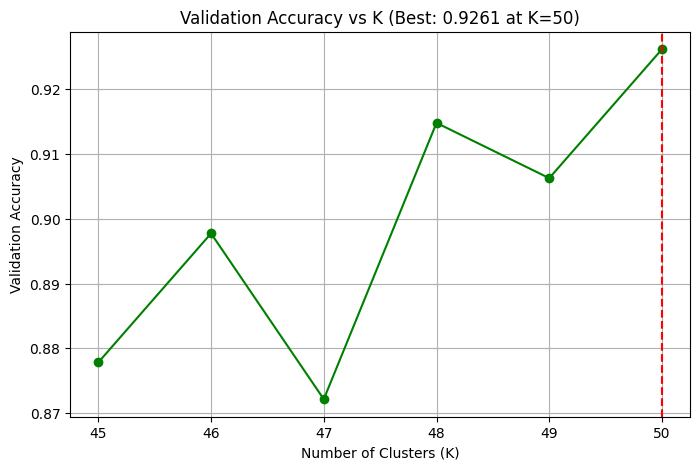

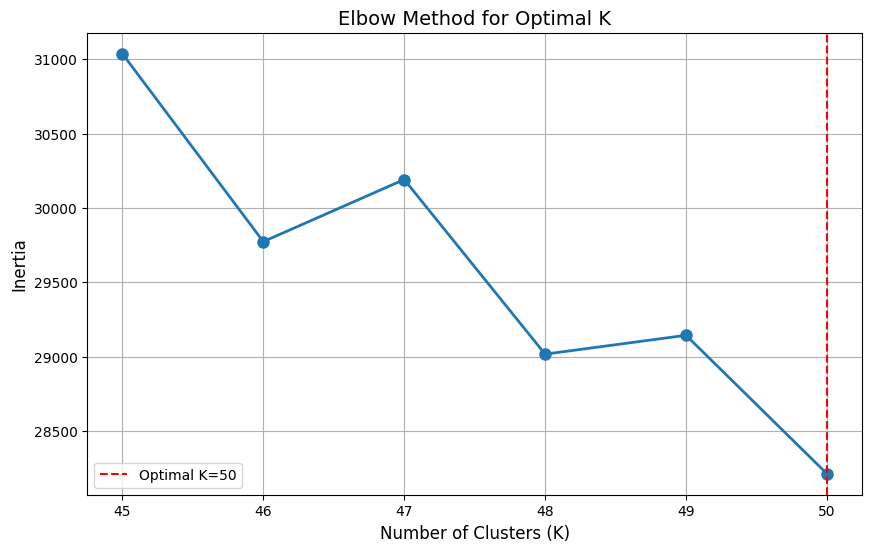

Selected K: 50 (validation accuracy: 0.9261)
Optimal K = 50


In [22]:
# Initialize K-means model
kmeans_model = KMeans()

# Find optimal K using validation set
print("Finding optimal K without PCA...")
k_range = range(45, 51)
optimal_k_no_pca, val_accuracy_no_pca, inertia_values_no_pca = find_optimal_k(kmeans_model, X_train_norm, X_val_norm, y_val, k_range)
print(f"Optimal K = {optimal_k_no_pca}")

In [23]:
# Train with optimal K
print("Training with optimal K (only LDA)...")
train_labels_no_pca, centroids_no_pca = kmeans_model.fit(X_train_norm, optimal_k_no_pca, n_init=25, max_iters=300)

# Calculate training accuracy
mapped_train_labels = enhanced_map_clusters_to_speakers(train_labels_no_pca, y_train)
mapped_train_labels_no_pca = enhanced_map_clusters_to_speakers(train_labels_no_pca, y_train)
train_accuracy_no_pca = evaluate(y_train, mapped_train_labels_no_pca)

print(f"Training Accuracy for LDA: {train_accuracy_no_pca:.4f}")

Training with optimal K (only LDA)...
Average cluster purity: 0.9196
Average cluster purity: 0.9196
Training Accuracy for LDA: 0.8861


Finding optimal K (LDA+PCA)...
Testing K = 45
Inertia: 28041.17
Average cluster purity: 0.9177
Validation Accuracy: 0.8807
Testing K = 46
Inertia: 28141.82
Average cluster purity: 0.9218
Validation Accuracy: 0.8949
Testing K = 47
Inertia: 27934.85
Average cluster purity: 0.9340
Validation Accuracy: 0.8892
Testing K = 48
Inertia: 27423.55
Average cluster purity: 0.9243
Validation Accuracy: 0.8920
Testing K = 49
Inertia: 27027.54
Average cluster purity: 0.9440
Validation Accuracy: 0.9403
Testing K = 50
Inertia: 26646.22
Average cluster purity: 0.9422
Validation Accuracy: 0.9318


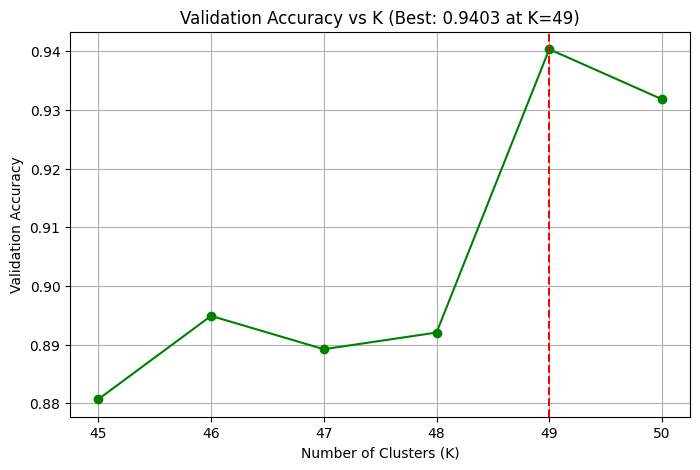

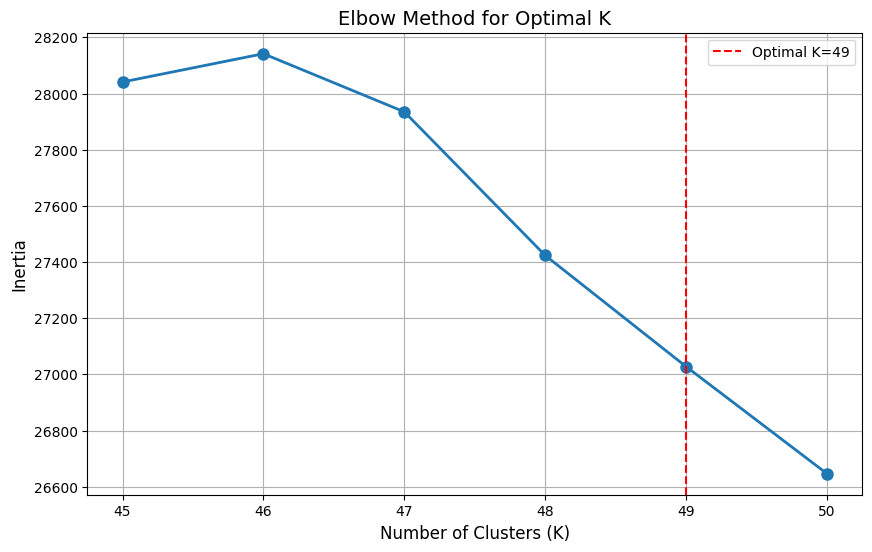

Selected K: 49 (validation accuracy: 0.9403)
Training with optimal K using LDA and PCA...
Average cluster purity: 0.9365
Average cluster purity: 0.9250


In [24]:
# Find optimal K using validation set for with PCA
print("Finding optimal K (LDA+PCA)...")
k_range = range(45, 51)
optimal_k_pca, val_accuracy_pca, inertia_values_pca = find_optimal_k(kmeans_model, X_train_pca, X_val_pca, y_val, k_range)

# Train with optimal K for PCA
print("Training with optimal K using LDA and PCA...")
train_labels_pca, centroids_pca = kmeans_model.fit(X_train_pca, optimal_k_pca, n_init=25, max_iters=300)
mapped_train_labels_pca = enhanced_map_clusters_to_speakers(train_labels_pca, y_train)
train_accuracy_pca = evaluate(y_train, mapped_train_labels_pca)

# Generate results for with PCA
test_labels_pca = kmeans_model.predict(X_test_pca)
mapped_test_labels_pca = enhanced_map_clusters_to_speakers(test_labels_pca, y_test)
test_accuracy_pca = evaluate(y_test, mapped_test_labels_pca)

Generating cluster purity visualization (LDA)...


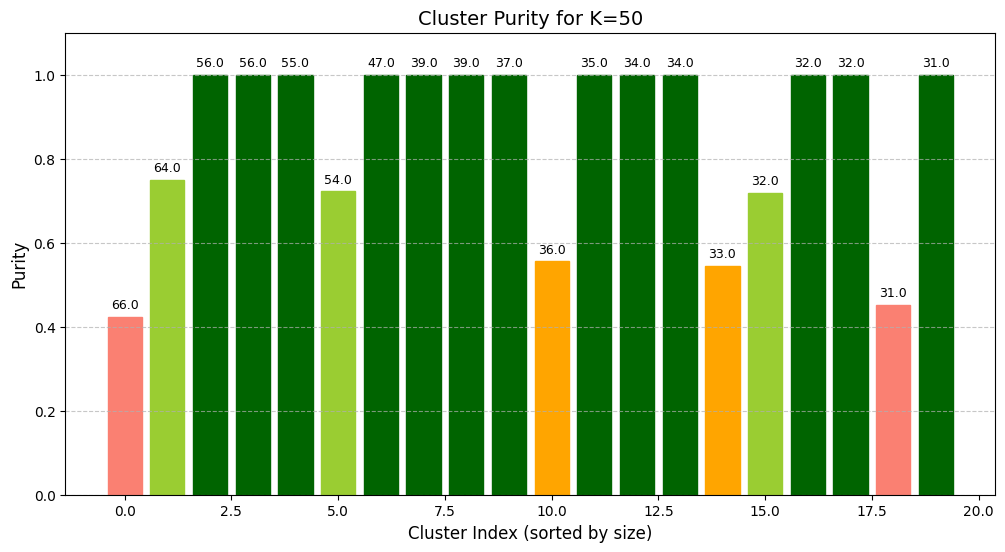

In [25]:
# Generate cluster purity visualization
print("Generating cluster purity visualization (LDA)...")
cluster_purities, cluster_sizes, confusion = calculate_cluster_purity(train_labels_no_pca, y_train)
plot_cluster_purity(cluster_purities, cluster_sizes, optimal_k_no_pca)

Generating speaker distribution visualization (LDA)...


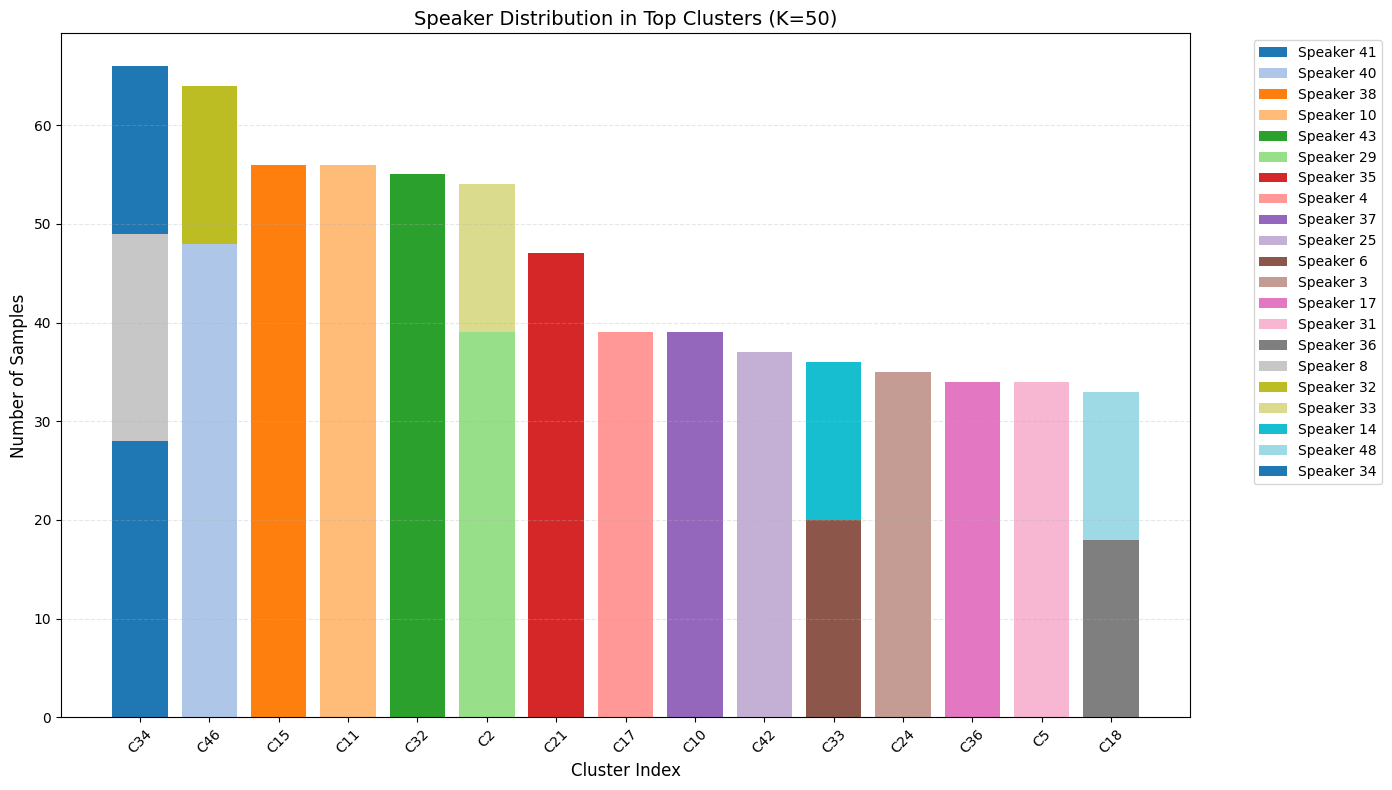

In [26]:
# Generate speaker distribution visualization without PCA
print("Generating speaker distribution visualization (LDA)...")
unique_clusters = np.unique(train_labels_no_pca)
unique_speakers = np.unique(y_train)
plot_speaker_distribution(confusion, unique_clusters, unique_speakers, optimal_k_no_pca)

In [27]:
# Predict test labels and evaluate
test_labels = kmeans_model.predict(X_test_pca, centroids=centroids_pca)
#if X_test_pca is not None else kmeans_model.predict(X_test_norm, centroids=centroids_no_pca)
mapped_test_labels = enhanced_map_clusters_to_speakers(test_labels, y_test)
test_accuracy_no_pca = evaluate(y_test, mapped_test_labels)

print(f"Test Accuracy: {test_accuracy_no_pca:.4f}")

Average cluster purity: 0.9250
Test Accuracy: 0.8767


In [28]:
print("\nFinal Results:")
print(f"Training Accuracy without PCA: {train_accuracy_no_pca:.4f}")
print(f"Validation Accuracy without PCA: {val_accuracy_no_pca:.4f}")
print(f"Test Accuracy without PCA: {test_accuracy_no_pca:.4f}")


Final Results:
Training Accuracy without PCA: 0.8861
Validation Accuracy without PCA: 0.9261
Test Accuracy without PCA: 0.8767


Generating cluster purity visualization (LDA+PCA)...


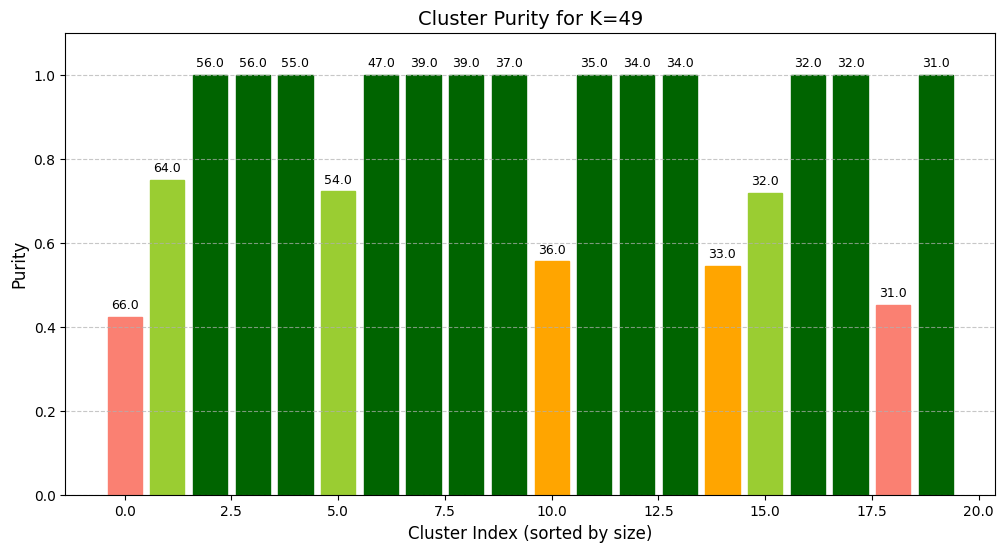

In [29]:
# Generate cluster purity visualization
print("Generating cluster purity visualization (LDA+PCA)...")
cluster_purities_pca, cluster_sizes_pca, confusion_pca = calculate_cluster_purity(train_labels_pca, y_train)
plot_cluster_purity(cluster_purities, cluster_sizes, optimal_k_pca)

Generating speaker distribution visualization with LDA+PCA...


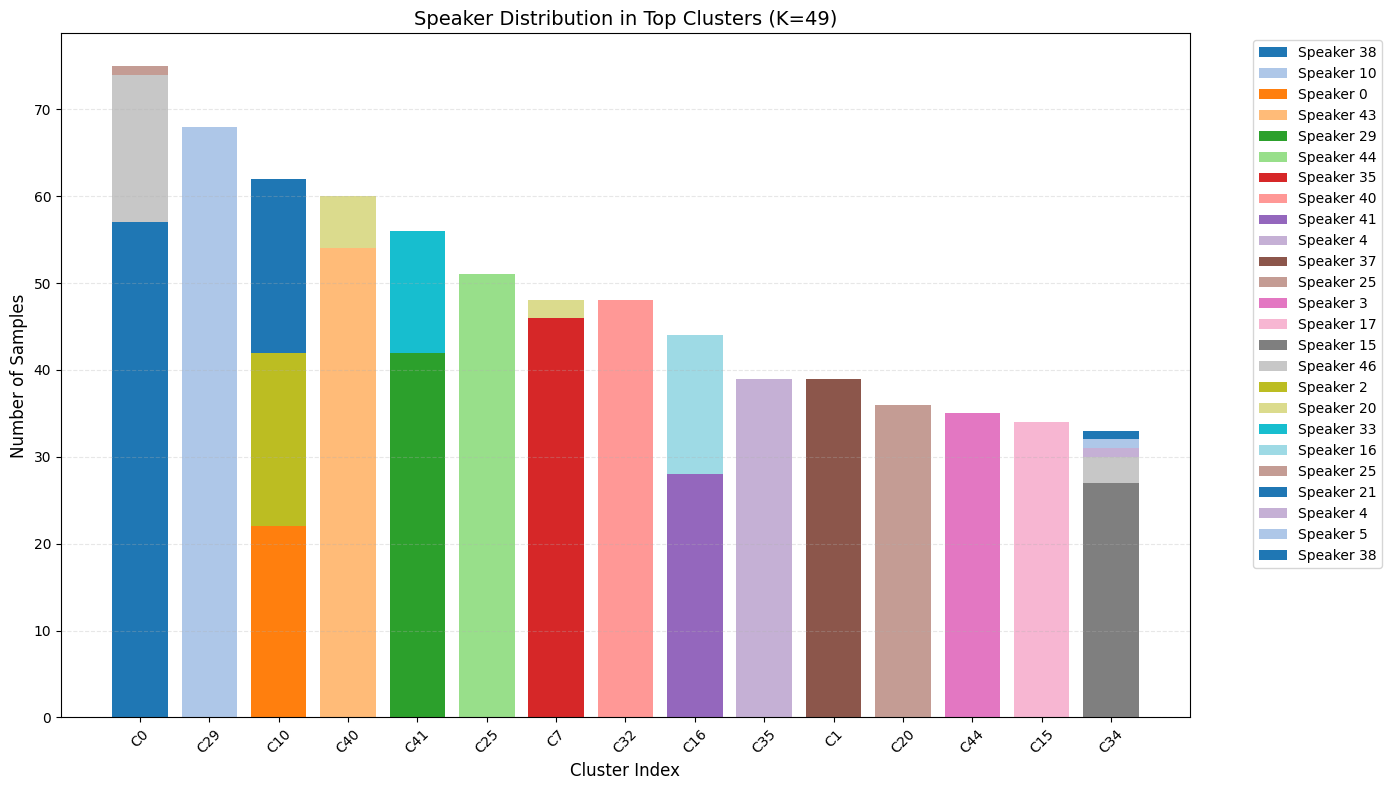

In [30]:
# Generate speaker distribution visualization with PCA
print("Generating speaker distribution visualization with LDA+PCA...")
unique_clusters_pca = np.unique(train_labels_pca)
unique_speakers_pca = np.unique(y_train)
plot_speaker_distribution(confusion_pca, unique_clusters_pca, unique_speakers_pca, optimal_k_pca)

In [31]:
# Generate results for with PCA
test_labels_pca = kmeans_model.predict(X_test_pca)
mapped_test_labels_pca = enhanced_map_clusters_to_speakers(test_labels_pca, y_test)
test_accuracy_pca = evaluate(y_test, mapped_test_labels_pca)
print(f"Test Accuracy with LDA+PCA: {test_accuracy_pca:.4f}")

Average cluster purity: 0.9250
Test Accuracy with LDA+PCA: 0.8767



Evaluating raw features without LDA...
Testing K = 45
Inertia: 4672590.50
Average cluster purity: 0.4607
Validation Accuracy: 0.0881
Testing K = 46
Inertia: 4701366.50
Average cluster purity: 0.4638
Validation Accuracy: 0.0881
Testing K = 47
Inertia: 4684830.50
Average cluster purity: 0.4735
Validation Accuracy: 0.0909
Testing K = 48
Inertia: 4658384.00
Average cluster purity: 0.6768
Validation Accuracy: 0.0824
Testing K = 49
Inertia: 4649484.00
Average cluster purity: 0.3320
Validation Accuracy: 0.0824
Testing K = 50
Inertia: 4654394.00
Average cluster purity: 0.4756
Validation Accuracy: 0.0767


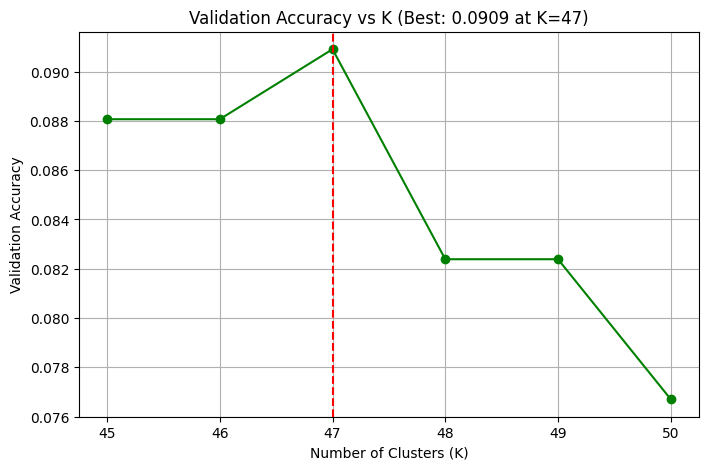

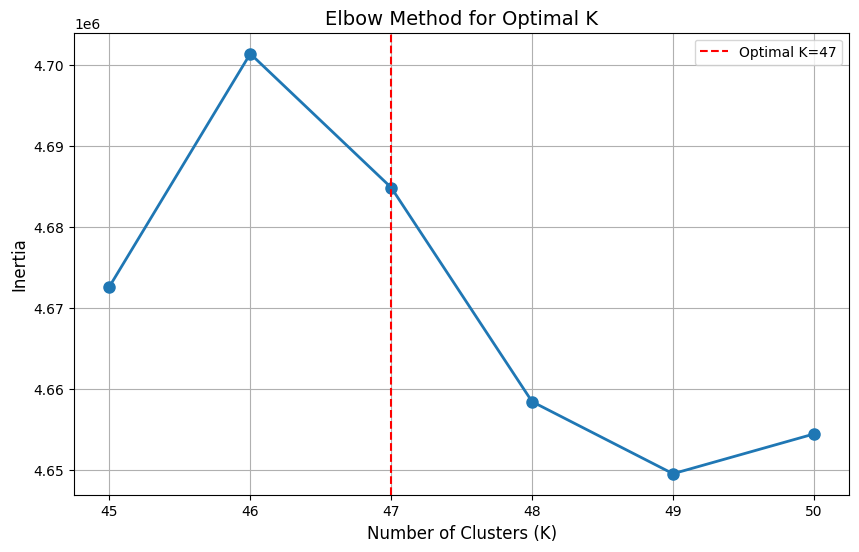

Selected K: 47 (validation accuracy: 0.0909)
Average cluster purity: 0.4101
Average cluster purity: 0.5946


In [32]:
# Raw features evaluation
print("\nEvaluating raw features without LDA...")
optimal_k_raw, val_accuracy_raw, _ = find_optimal_k(kmeans_model, X_raw_train_norm, X_raw_val_norm, y_val, k_range)
train_labels_raw, _ = kmeans_model.fit(X_raw_train_norm, optimal_k_raw, n_init=25, max_iters=300)
mapped_train_labels_raw = enhanced_map_clusters_to_speakers(train_labels_raw, y_train)
train_accuracy_raw = evaluate(y_train, mapped_train_labels_raw)
test_labels_raw = kmeans_model.predict(X_raw_test_norm)
test_accuracy_raw = evaluate(y_test, enhanced_map_clusters_to_speakers(test_labels_raw, y_test))


Final Results:
LDA+PCA 	 Train: 0.9103 Val: 0.9403 Test: 0.8767
LDA Only 	 Train: 0.8861 Val: 0.9261 Test: 0.8767
Raw Features 	 Train: 0.0868 Val: 0.0909 Test: 0.3727


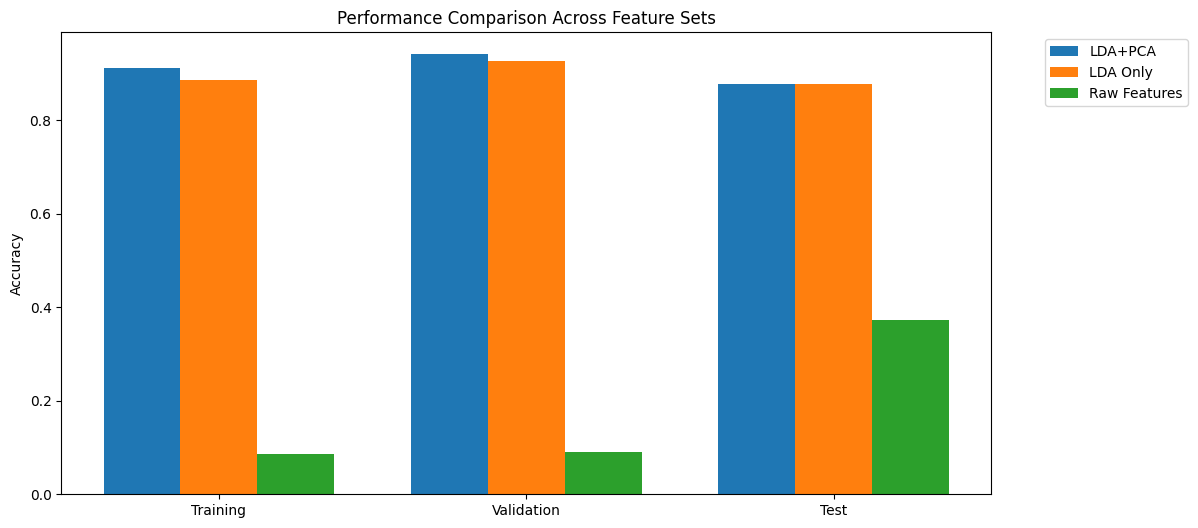

In [35]:
print("\nFinal Results:")
print(f"LDA+PCA \t Train: {train_accuracy_pca:.4f} Val: {val_accuracy_pca:.4f} Test: {test_accuracy_pca:.4f}")
print(f"LDA Only \t Train: {train_accuracy_no_pca:.4f} Val: {val_accuracy_no_pca:.4f} Test: {test_accuracy_no_pca:.4f}")
print(f"Raw Features \t Train: {train_accuracy_raw:.4f} Val: {val_accuracy_raw:.4f} Test: {test_accuracy_raw:.4f}")

plot_performance_comparison(
    [train_accuracy_pca, val_accuracy_pca, test_accuracy_pca],
    [train_accuracy_no_pca, val_accuracy_no_pca, test_accuracy_no_pca],
    [train_accuracy_raw, val_accuracy_raw, test_accuracy_raw]
)